In [100]:
import cv2
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import os
from skimage.feature import greycomatrix, greycoprops
from skimage import data

In [101]:
train_path="D:/train_tomato2"  
# get the training labels
import os

train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()
print(np.array(train_labels).shape)


(3L,)


('TRAINING_NAME', 'Tomato_early_blight')
('current_label', 'Tomato_early_blight')
[STATUS] processed folder: Tomato_early_blight
('TRAINING_NAME', 'Tomato_healthy')
('current_label', 'Tomato_healthy')
[STATUS] processed folder: Tomato_healthy
('TRAINING_NAME', 'Tomato_late_blight')
('current_label', 'Tomato_late_blight')
[STATUS] processed folder: Tomato_late_blight
[STATUS] training Labels (15L,)


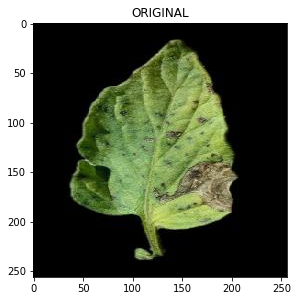

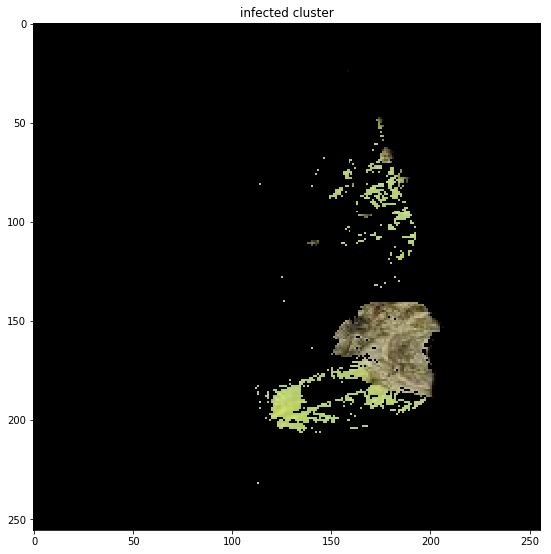

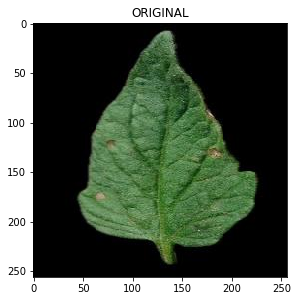

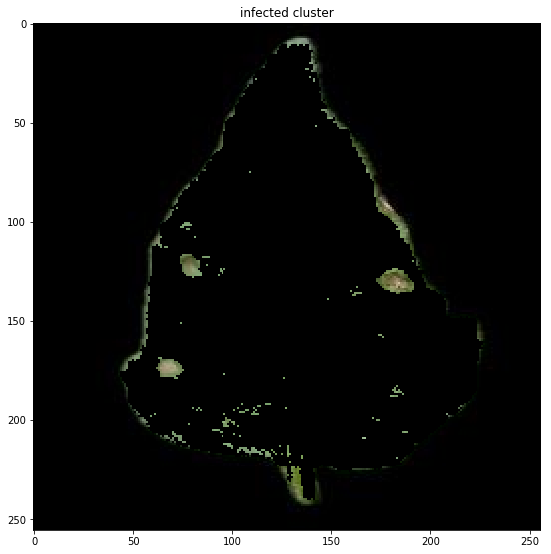

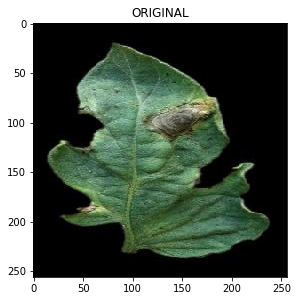

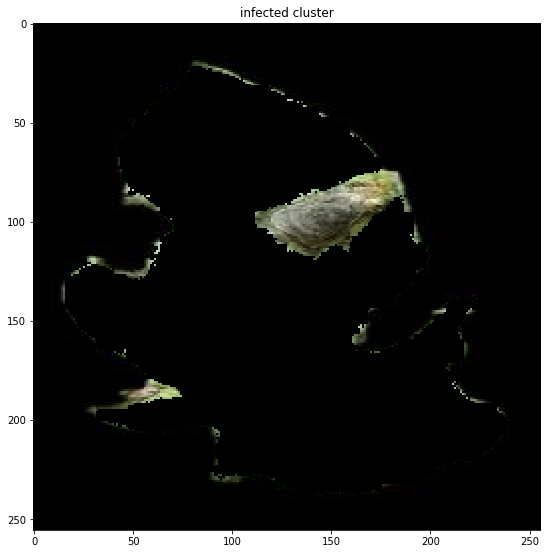

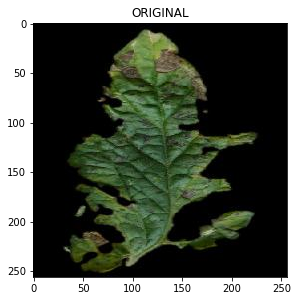

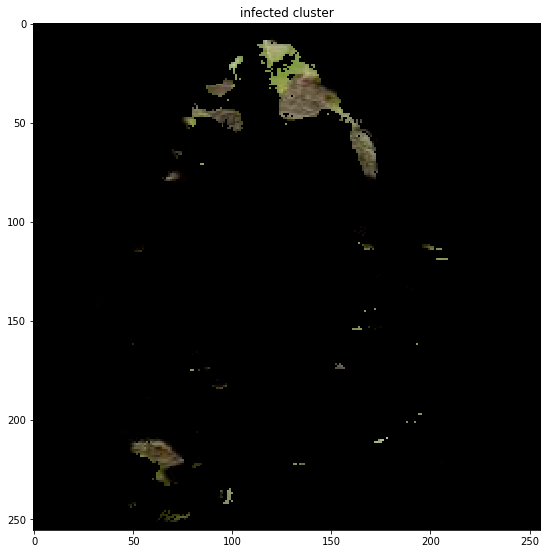

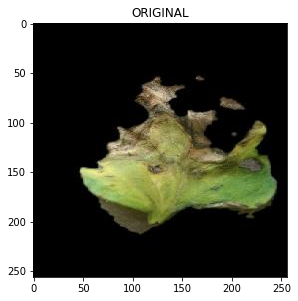

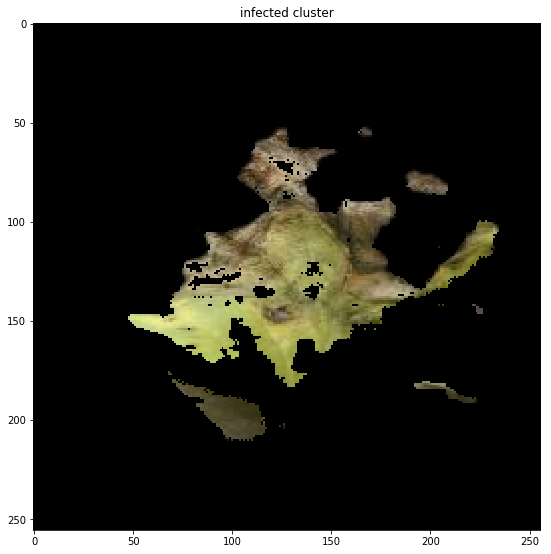

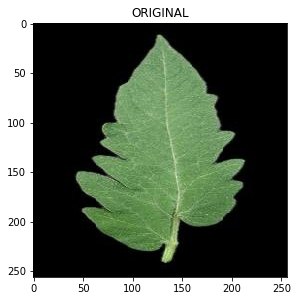

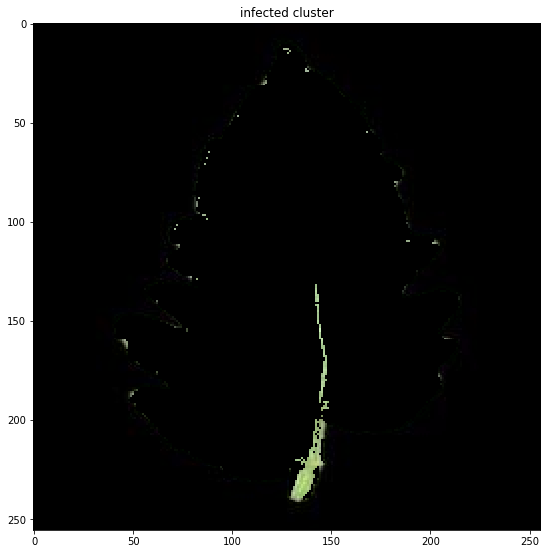

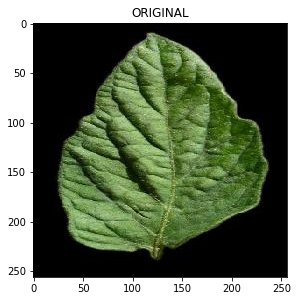

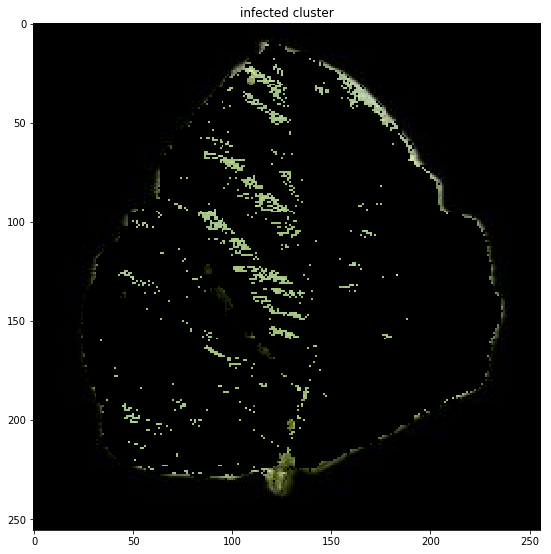

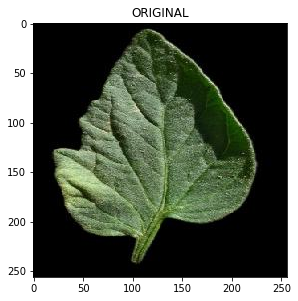

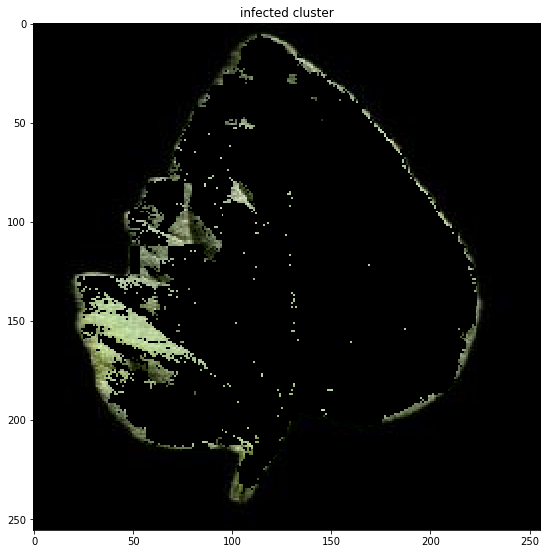

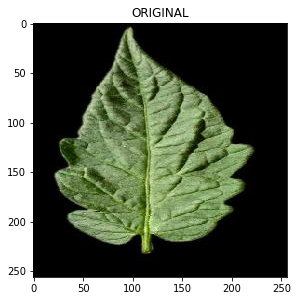

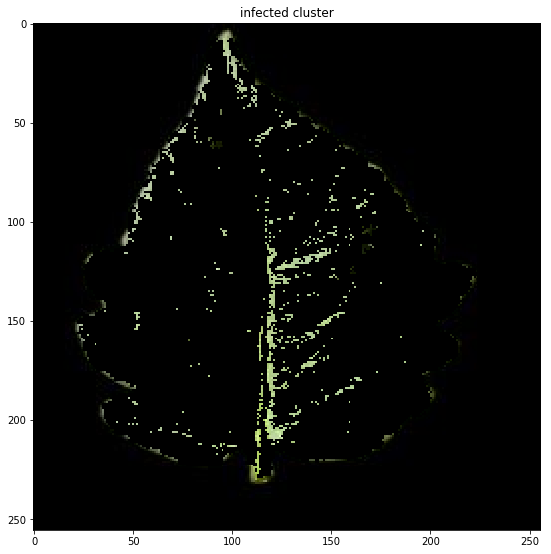

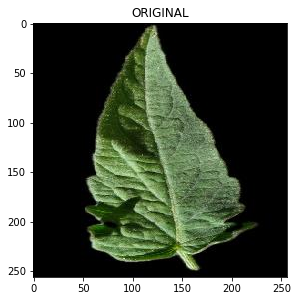

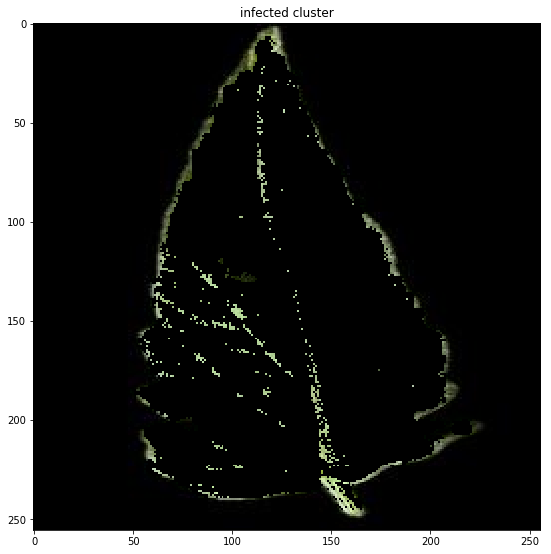

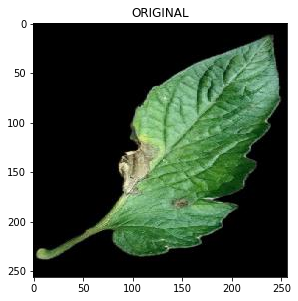

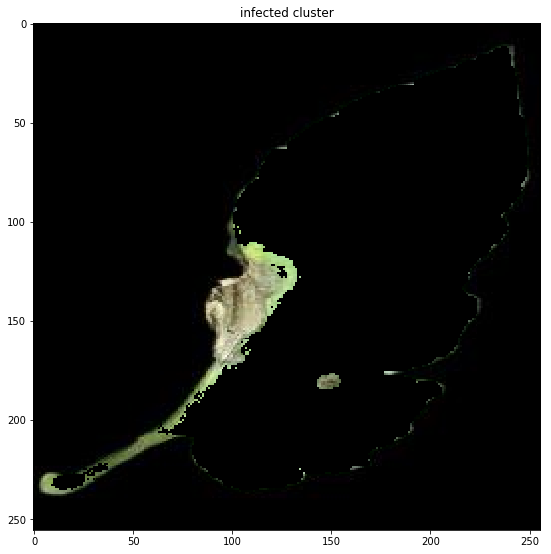

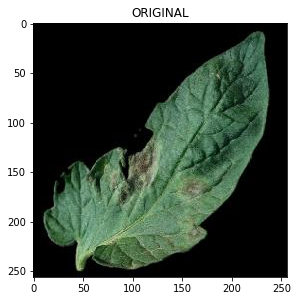

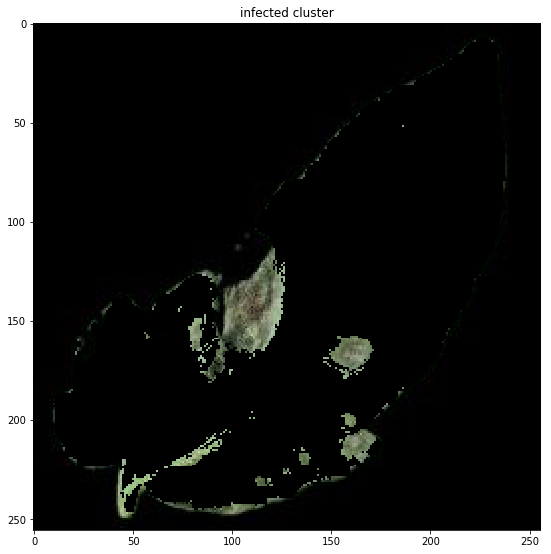

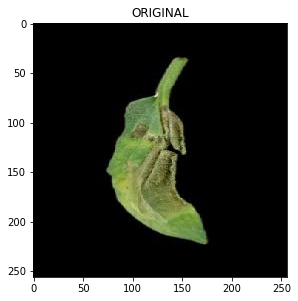

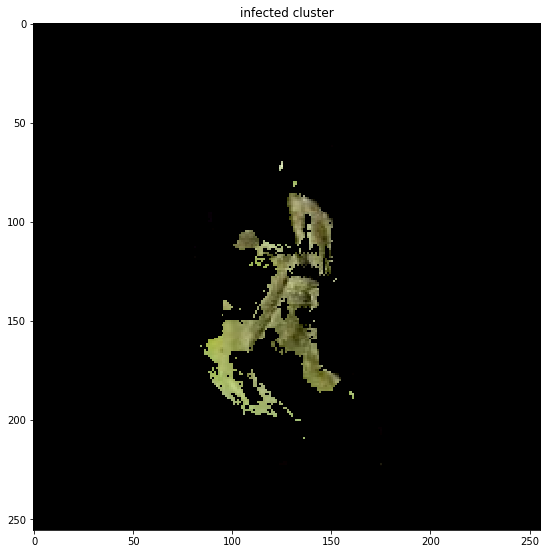

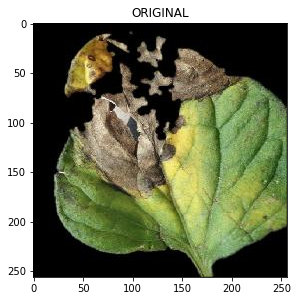

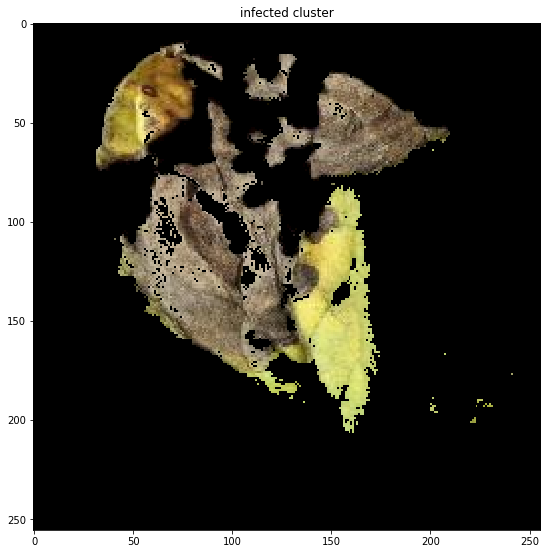

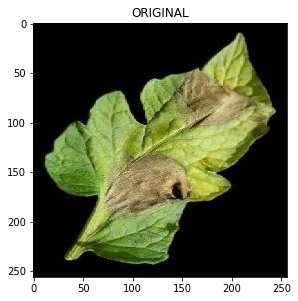

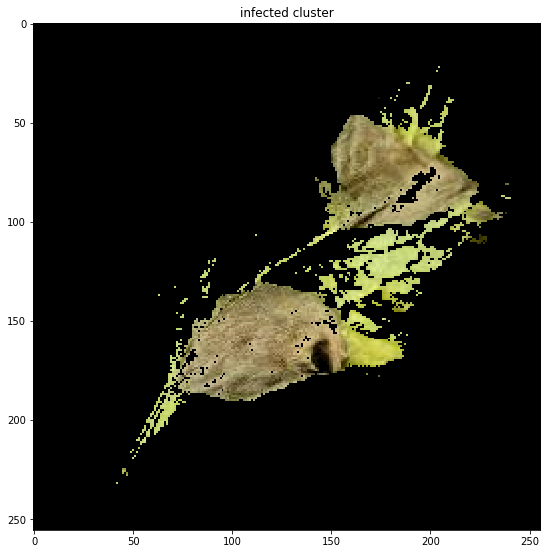

In [99]:
import scipy
# empty lists to hold feature vectors and labels
global_features = []
labels = []
img_mode=[]
i, j = 0, 0
k = 0


for training_name in train_labels:
        # join the training data path and each species training folder
    img_list = os.listdir(train_path + '/' + training_name)
    print('TRAINING_NAME',training_name)
    current_label = training_name
    print('current_label',current_label)
    k = 1
    for img in img_list:
            image=train_path + '/' + training_name+'/' + img
            ip_img = cv2.imread(image,cv2.IMREAD_UNCHANGED)
            height,width=ip_img.shape[:2]
            plt.figure(figsize=(10, 10))
            b,g,r = cv2.split(ip_img)       # get b,g,r
            ip_img = cv2.merge([r,g,b])     # switch it to rgb
            fixed_size=(height,width)
#             plt.subplots_adjust(bottom=1.0, right=1.8, top=3.0, wspace = 0.5, hspace=0.5)
            plt.subplot(12
                        1),plt.imshow(ip_img),plt.title('ORIGINAL')
#             fixed_size=(256,256)
            image = cv2.resize(ip_img, fixed_size)
#             image=ip_img
#             plt.subplot(662),plt.imshow(image),plt.title('Resized Image')
            ###HISTOGRAM EQUALIZATION####
            img_out = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            img_out[:,:,0]=cv2.equalizeHist(img_out[:,:,0])
            img_equi=cv2.cvtColor(img_out, cv2.COLOR_YUV2BGR)
#             plt.subplot(663),plt.imshow(img_equi),plt.title('EQUILIZED IMAGE')
          ####RGB TO LAB COLOR SPACE CONVERSION###
            plt.figure(figsize=(20, 20))    
            lab_image = cv2.cvtColor(img_equi, cv2.COLOR_BGR2LAB)
#             plt.subplot(664),plt.imshow(lab_image),plt.title('LAB_IMAGE')

            ###Splitting LAB Color Model####
#             plt.figure(figsize=(20, 20))    
            l_channel,a_channel,b_channel = cv2.split(lab_image)        
#             plt.subplot(665),plt.imshow(l_channel),plt.title('L Channel Image')
#             plt.subplot(666),plt.imshow(a_channel),plt.title('A Channel Image')
#             plt.subplot(667),plt.imshow(b_channel),plt.title('B Channel Image')
            ####k means clustering of B channel######
            vectorized=b_channel.reshape(-1,1)
            vectorized=np.float32(vectorized)
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
            k=3
            res1,label,center=cv2.kmeans(vectorized,k,None,
            criteria,10,cv2.KMEANS_RANDOM_CENTERS)
            center=np.uint8(center)
            c=(label.flatten())
            res2 = center[c.astype(int)]
            res3= res2.reshape((a_channel.shape))
            # c=(label==0).flatten()
            reshape_label=label.reshape(fixed_size)
#             plt.subplot(668),plt.imshow(reshape_label,cmap='gray')
#             plt.subplot(669),plt.imshow(res3)
            ####Finding Infected Cluster###########3
            num1=center[0]
            num2=center[1]
            num3=center[2]
            if (num1 < num2) and (num1 < num3):
                smallest_num = num1
            elif (num2 < num1) and (num2 < num3):
                smallest_num = num2
            else:
                smallest_num = num3
#             print("The smallest of the 3 numbers is : ", smallest_num)

            cluster1=np.zeros(lab_image.shape,np.uint8)
            cluster2=np.zeros(lab_image.shape,np.uint8)
            cluster3=np.zeros(lab_image.shape,np.uint8)
            cluster4=np.zeros(lab_image.shape,np.uint8)
            for x in range(height-1):
                    for y in range(width-1):
                        if np.all((res3[x,y])==center[0]):
                            cluster1[x,y]=image[x,y]
                            if smallest_num==center[0]:
                                infected_cluster=cluster1
                        elif np.all((res3[x,y])==center[1]):
                            cluster2[x,y]=image[x,y]
                            if smallest_num==center[1]:
                                infected_cluster=cluster2
                        elif np.all((res3[x,y])==center[2]):
                            cluster3[x,y]=image[x,y]   
                            if smallest_num==center[2]:
                                infected_cluster=cluster3
    #                     elif np.all((res3[x,y])==center[3]):
    #                         cluster4[x,y]=ip_img[x,y]

#             plt.figure(figsize=(16, 16))
#             plt.subplot(141),plt.imshow(cluster1),plt.title('cluster1')
#             plt.subplot(142),plt.imshow(cluster2),plt.title('cluster2')
#             plt.subplot(143),plt.imshow(cluster3),plt.title('cluster3')
            plt.subplot(122),plt.imshow(infected_cluster),plt.title('infected cluster')

        
            img_out = cv2.cvtColor(infected_cluster, cv2.COLOR_RGB2GRAY)
#             plt.subplot(144),plt.imshow(img_out, cmap='gray'),plt.title('Gray_infected_image')
            ##########Statistical Feature Extraction#######
            for x in range (1,height-1):
              for y in range (1,width-1):

                pixel = img_out[x,y]
                if np.all((img_out[x,y])!=0):
                    img_mode.append(img_out[x,y])
                
                y+=1
            x+=1
            
# a=scipy.stats.skew(img_mode)
            mean_g=(np.mean(img_mode))
            std_g=(np.std(img_mode))
            variance_g=(np.var(img_mode))
            skewness_g=scipy.stats.skew(img_mode)
            kurtosis_g=scipy.stats.kurtosis(img_mode,axis=0,fisher=False) #Pearson Kurtosis 
            mean_g=mean_g.reshape(-1,1)
            std_g=std_g.reshape(-1,1)
            variance_g=variance_g.reshape(-1,1)
            skewness_g=(np.array(skewness_g)).reshape(-1,1)
            kurtosis_g=(np.array(kurtosis_g)).reshape(-1,1)
            ####Finding highest and Lowest Intensity Value#####
            smallest = np.amin(img_out)
            biggest = np.amax(img_out)
#             print('smallest intensity',smallest)
#             print('Largest Intensity',biggest)
            
            
            
            ##########Textual_features_extrcation##########
            g = greycomatrix(img_out, [2], [0], levels=256,normed=True, symmetric=True)
    #         plt.subplot(667),plt.imshow(g, cmap='gray')
            contrast_g=greycoprops(g,'contrast')
            correlation_g=greycoprops(g,'correlation')
            energy_g=greycoprops(g,'energy')
                    # entropy_g=greycoprops(g,'entropy')
            homogeneity_g=greycoprops(g,'homogeneity')
            dissimilarity_g=greycoprops(g,'dissimilarity')
    
            global_feature = np.hstack(([mean_g,std_g,variance_g,kurtosis_g,skewness_g,contrast_g,correlation_g,energy_g,homogeneity_g,dissimilarity_g]))
#             print('global_feature is',global_feature)
            labels.append(current_label)
            global_features.append(global_feature)

            i += 1
            k += 1
    #         print('k is',k)
    #         print('i is',i)
    print( "[STATUS] processed folder: {}".format(current_label))
#     print('GLOBAL FEATURE SHAPE',np.array(global_features).shape)

    j += 1
#         print('j is',j)
    # get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))
# cv2.imshow('L PART',l_channel)
# cv2.imshow('A PART',a_channel)
# # cv2.imshow('B PART',b_channel)
# # Print the minimum and maximum of lightness.
# print (np.min(l_channel)) # 0
# print (np.max(l_channel))  # 255

# # Print the minimum and maximum of a.
# print (np.min(a_channel))  # 42
# print (np.max(a_channel))  # 226

# # Print the minimum and maximum of b.
# print (np.min(b_channel))  # 20
# print (np.max(b_channel))  # 223
# cv2.imshow('EQUALIZED RGB IMAGE',img_equi)
# cv2.imshow('Input Image',ip_img)
img_out=cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB)
# plt.imshow(img_out)

In [57]:
global_features=np.array(global_features).reshape(-1,10)
print ("[STATUS] completed Global Feature Extraction...")
# get the overall feature vector size
print ("[STATUS] feature vector size {}".format(np.array(global_features).shape))
# get the overall training label size
print ("[STATUS] training Labels {}".format(np.array(labels).shape))
# encode the target labels
targetNames = np.unique(labels)
print(targetNames)

[STATUS] completed Global Feature Extraction...
[STATUS] feature vector size (669L, 10L)
[STATUS] training Labels (669L,)
['Tomato_Early_blight' 'Tomato_Healthy' 'Tomato___Late_blight']


In [58]:
b_channel.shape

(256L, 256L)

In [59]:
# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
# # encode the target labels
# targetNames = np.unique(labels)
# print(labels)
le = LabelEncoder()
print('Label',le)
target = le.fit_transform(labels)
print(target)
print ("[STATUS] training labels encoded...",np.array(labels).shape)

('Label', LabelEncoder())
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [60]:
# organize imports
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
rescaled_features = scaler.fit_transform(global_features)


In [61]:
print ("[STATUS] feature vector normalized...")

print ("[STATUS] target labels: {}".format(target))
print ("[STATUS] target labels shape: {}".format(target.shape))

[STATUS] feature vector normalized...
[STATUS] target labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2

In [62]:
# save the feature vector using HDF5
import h5py
h5f_data = h5py.File('d:/new_output/data1.h5', 'w')
h5f_data.create_dataset('dataset_1', data=np.array(global_features))

h5f_label = h5py.File('d:/new_output/labels1.h5', 'w')
h5f_label.create_dataset('dataset_1', data=np.array(target))

h5f_data.close()
h5f_label.close()
print ("[STATUS] end of training..")

[STATUS] end of training..


In [63]:
import glob
import cv2
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.externals import joblib

In [92]:
models = []
models.append(('LR', LogisticRegression(random_state=9)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=9)))
models.append(('RF', RandomForestClassifier(n_estimators=100, random_state=9)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=9)))

# variables to hold the results and names
results = []
names = []
scoring = "accuracy"

# import the feature vector and trained labels
h5f_data = h5py.File('D:/new_output/data1.h5', 'r')
h5f_label = h5py.File('D:/new_output/labels1.h5', 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print ("[STATUS] features shape: {}".format(global_features.shape))
print ("[STATUS] labels shape: {}".format(global_labels.shape))

print ("[STATUS] training started...")

[STATUS] features shape: (669L, 10L)
[STATUS] labels shape: (669L,)
[STATUS] training started...


In [93]:
# train_test_split size
test_size = 0.10
# seed for reproducing same results
# seed = 9
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=None)

print ("[STATUS] splitted train and test data...")
print ("Train data  : {}".format(trainDataGlobal.shape))
print ("Test data   : {}".format(testDataGlobal.shape))
print ("Train labels: {}".format(trainLabelsGlobal.shape))
print ("Test labels : {}".format(testLabelsGlobal.shape))
print(testLabelsGlobal.size)
print(trainDataGlobal.size)

[STATUS] splitted train and test data...
Train data  : (602L, 10L)
Test data   : (67L, 10L)
Train labels: (602L,)
Test labels : (67L,)
67
6020


('predictions', array([2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 0,
       0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 1, 0,
       0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2,
       2], dtype=int64))
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        31

   micro avg       1.00      1.00      1.00        67
   macro avg       1.00      1.00      1.00        67
weighted avg       1.00      1.00      1.00        67

('TEST LABELS', array([2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 1, 2, 1, 0,
       0, 2, 1, 2, 0, 2, 2, 2, 2, 0, 1, 0, 2, 0, 0, 1, 1, 1, 2, 2, 1, 0,
       0, 1, 2, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 2, 0, 0, 0, 2, 2, 1, 1, 2,
       2], dtype=int64))
('Score', 1.0)


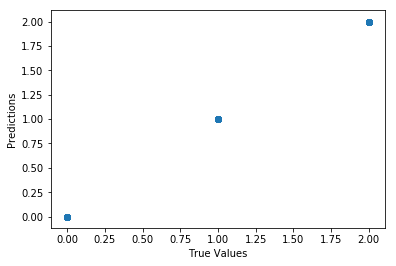

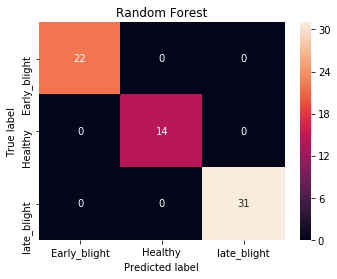

In [94]:
import pandas as pd
import seaborn as sns
clf = RandomForestClassifier(n_estimators=100, random_state=9)

# anova_svm = make_pipeline(anova_filter, clf)
model=clf.fit(trainDataGlobal, trainLabelsGlobal)
y_pred = model.predict(testDataGlobal)
print("predictions",y_pred)
print(classification_report(testLabelsGlobal, y_pred))
print("TEST LABELS",testLabelsGlobal)
plt.scatter(testLabelsGlobal, y_pred)
plt.xlabel("True Values")
plt.ylabel("Predictions")
print ("Score", model.score(testDataGlobal, testLabelsGlobal))
cm=confusion_matrix(testLabelsGlobal,y_pred)
# #extracting true_positives, false_positives, true_negatives, false_negatives
# tn, fp, fn, tp = confusion_matrix(testLabelsGlobal, y_pred).ravel()
# print("True Negatives: ",tn)
# print("False Positives: ",fp)
# print("False Negatives: ",fn)
# print("True Positives: ",tp)
plt.figure(figsize=(5.5,4))
cm_df = pd.DataFrame(cm,
                     index = ['Early_blight','Healthy','late_blight'], 
                     columns = ['Early_blight','Healthy','late_blight'])
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

LR: 0.965124 (0.007001)
LDA: 0.968449 (0.009352)
KNN: 0.837214 (0.004515)
CART: 0.965141 (0.017679)
RF: 0.981725 (0.002369)
NB: 0.970091 (0.007077)
SVM: 0.433524 (0.035038)


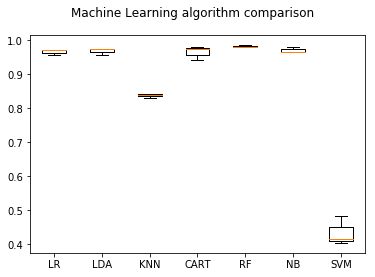

In [95]:
import warnings
warnings.filterwarnings('ignore')

# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=3, random_state=7)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [96]:
import matplotlib.pyplot as plt
# create the classifier
print ('[STATUS] Creating the classifier..')
clf_rf = RandomForestClassifier(n_estimators=100, random_state=9)

# fit the training data and labels
print ('[STATUS] Fitting data/label to model..')
clf_rf.fit(trainDataGlobal, trainLabelsGlobal)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[STATUS] Creating the classifier..
[STATUS] Fitting data/label to model..


('global_feature is', array([[6.75051534e+01, 7.69211494e+01, 5.91686323e+03, 1.79910968e+00,
        6.26645875e-01, 5.20043676e+02, 7.99474259e-01, 8.40277801e-01,
        8.81828802e-01, 4.50350640e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(1L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

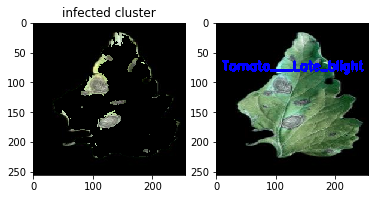

('global_feature is', array([[7.18507960e+01, 7.62455792e+01, 5.81338834e+03, 1.66987622e+00,
        4.90092640e-01, 1.08942298e+02, 7.16143079e-01, 9.85190223e-01,
        9.85690012e-01, 9.17568898e-01]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(2L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

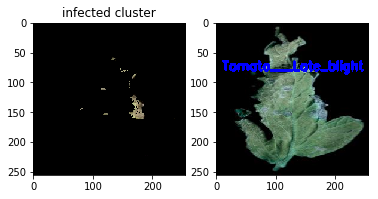

('global_feature is', array([[8.68790680e+01, 7.36637684e+01, 5.42635077e+03, 1.54724228e+00,
        1.20900408e-01, 3.63319882e+02, 8.16620530e-01, 9.32026005e-01,
        9.34129712e-01, 3.50553642e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(3L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

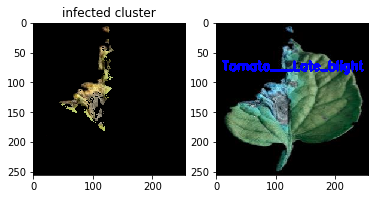

('global_feature is', array([[6.73769202e+01, 7.02715429e+01, 4.93808975e+03, 1.82838074e+00,
        5.38406986e-01, 2.89714382e+02, 7.18283559e-01, 8.36382325e-01,
        8.86256747e-01, 3.42879552e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(4L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

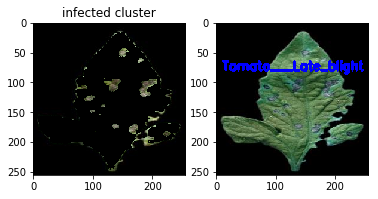

('global_feature is', array([[6.64007634e+01, 6.23486752e+01, 3.88735730e+03, 2.32471299e+00,
        6.39884136e-01, 8.11128353e+01, 8.94736589e-01, 8.92583958e-01,
        9.08355540e-01, 1.58736774e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(5L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

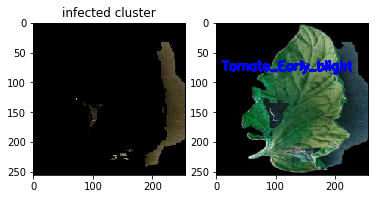

('global_feature is', array([[6.96149284e+01, 5.99510780e+01, 3.59413176e+03, 2.33343845e+00,
        5.32922695e-01, 2.33607622e+02, 8.08087055e-01, 9.21230235e-01,
        9.24926795e-01, 2.86783342e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(6L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

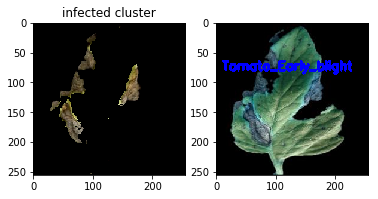

('global_feature is', array([[6.48965002e+01, 5.78900294e+01, 3.35125550e+03, 2.45211334e+00,
        6.00855178e-01, 4.51392993e+02, 7.46182353e-01, 7.71265442e-01,
        8.15737845e-01, 5.68786909e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(7L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

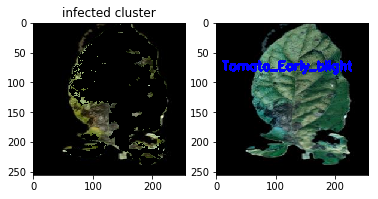

('global_feature is', array([[5.84003094e+01, 5.76632341e+01, 3.32504856e+03, 2.60794379e+00,
        7.55048845e-01, 3.05333661e+02, 6.15751226e-01, 8.15849221e-01,
        8.70098374e-01, 3.64948327e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(8L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

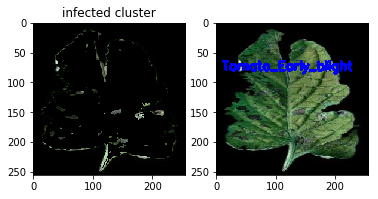

('global_feature is', array([[6.06488833e+01, 5.86280220e+01, 3.43724496e+03, 2.47746277e+00,
        6.97795999e-01, 1.50494279e+02, 8.50062080e-01, 9.67627630e-01,
        9.68925763e-01, 1.48557456e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(9L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

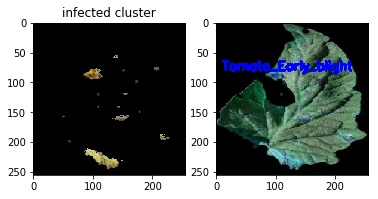

('global_feature is', array([[5.66137276e+01, 5.77457521e+01, 3.33457188e+03, 2.64960830e+00,
        8.01409707e-01, 2.05987389e+02, 6.12209679e-01, 8.46866915e-01,
        8.91326679e-01, 2.69921875e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(10L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

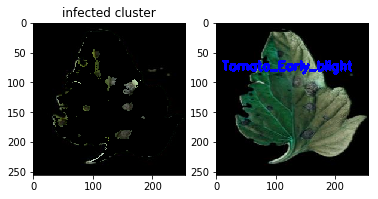

('global_feature is', array([[5.28464492e+01, 5.73719528e+01, 3.29154096e+03, 2.78083956e+00,
        8.96007010e-01, 1.59935439e+02, 5.68869833e-01, 8.63288721e-01,
        9.12159016e-01, 1.86851009e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(11L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

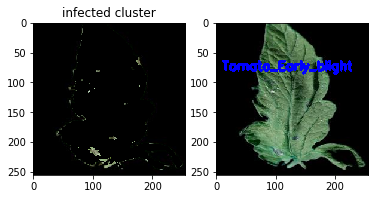

('global_feature is', array([[5.19929005e+01, 5.73570375e+01, 3.28982975e+03, 2.74080364e+00,
        8.96840646e-01, 5.33107130e+02, 2.79956962e-01, 8.86328763e-01,
        9.15237540e-01, 4.60965182e+00]]))
('PREDICTION RESULT', 0)
[STATUS] PREDICTION ARRAY(12L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

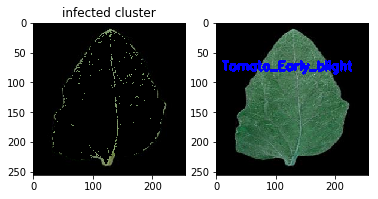

('global_feature is', array([[1.26629597e+02, 1.07180376e+02, 1.14876331e+04, 1.29520352e+00,
        1.10357583e-01, 2.17127161e+03, 9.20021525e-01, 4.90591448e-01,
        8.03076877e-01, 1.03389979e+01]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(13L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

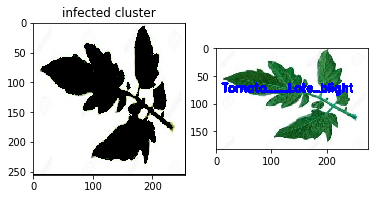

('global_feature is', array([[ 1.56176762e+02,  1.07552085e+02,  1.15674510e+04,
         1.37891615e+00, -3.87366718e-01,  1.86777634e+03,
         9.38979691e-01,  5.20845549e-01,  8.17129722e-01,
         9.37849102e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(14L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

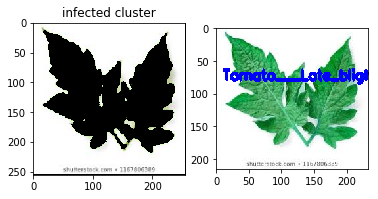

('global_feature is', array([[ 1.52373391e+02,  1.08473171e+02,  1.17664289e+04,
         1.33255452e+00, -3.28473095e-01,  4.78059978e+02,
         3.93338223e-01,  8.88906010e-01,  9.23437799e-01,
         3.51660925e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(15L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

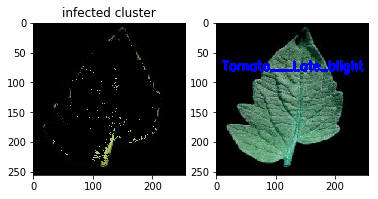

('global_feature is', array([[ 1.48396379e+02,  1.08872660e+02,  1.18532560e+04,
         1.29969478e+00, -2.66598597e-01,  8.36762395e+02,
         5.06450028e-01,  8.56894301e-01,  8.90026670e-01,
         6.48954232e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(16L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

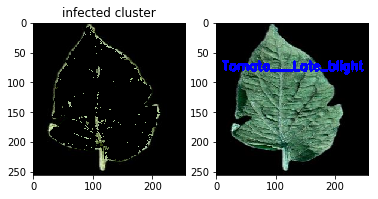

('global_feature is', array([[ 1.45161224e+02,  1.09269691e+02,  1.19398653e+04,
         1.27714840e+00, -2.17370404e-01,  5.86841966e+02,
         4.06003068e-01,  8.82258313e-01,  9.13315455e-01,
         4.49892347e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(17L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

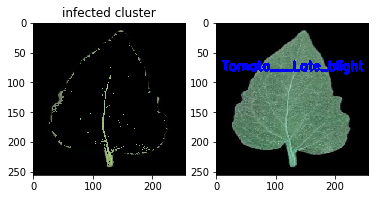

('global_feature is', array([[ 1.67049488e+02,  1.06838038e+02,  1.14143664e+04,
         1.56513536e+00, -5.96872733e-01,  1.20099440e+03,
         9.56075886e-01,  4.95505715e-01,  9.05740989e-01,
         5.72954601e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(18L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

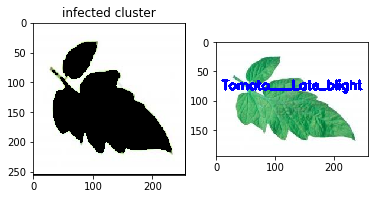

('global_feature is', array([[ 1.63177232e+02,  1.07852068e+02,  1.16320685e+04,
         1.48940575e+00, -5.30919080e-01,  2.81416016e+02,
         8.44793700e-01,  8.55698693e-01,  8.97857867e-01,
         3.03901636e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(19L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

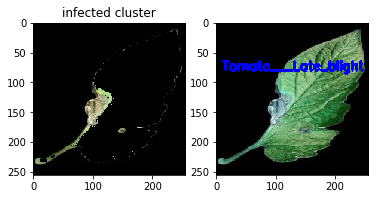

('global_feature is', array([[ 1.62757134e+02,  1.07356704e+02,  1.15254619e+04,
         1.49291636e+00, -5.22306286e-01,  3.86866480e+02,
         7.27487133e-01,  9.48620416e-01,  9.51131847e-01,
         3.13022884e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(20L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

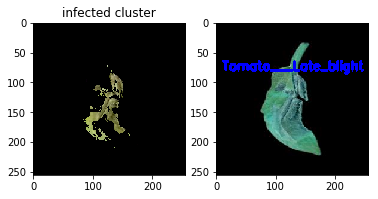

('global_feature is', array([[ 1.60936589e+02,  1.05108383e+02,  1.10477721e+04,
         1.51037082e+00, -4.86579728e-01,  1.07459446e+03,
         8.49244237e-01,  7.54482339e-01,  7.65654011e-01,
         1.02536602e+01]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(21L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

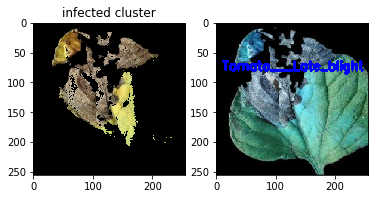

('global_feature is', array([[ 1.57399577e+02,  1.05943518e+02,  1.12240289e+04,
         1.45326316e+00, -4.27206058e-01,  3.75462721e+02,
         6.70441938e-01,  8.49765636e-01,  8.92345190e-01,
         3.57729454e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(22L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

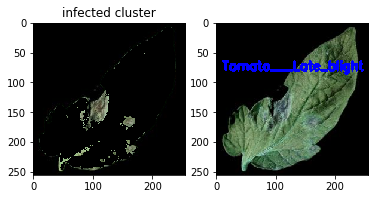

('global_feature is', array([[ 1.57243889e+02,  1.04340677e+02,  1.08869768e+04,
         1.49131844e+00, -4.28985565e-01,  1.24683074e+03,
         7.90944892e-01,  8.42636692e-01,  8.50959721e-01,
         8.56591412e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(23L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

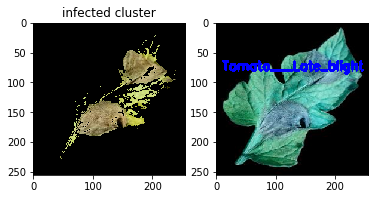

('global_feature is', array([[ 1.53654294e+02,  1.04684229e+02,  1.09587878e+04,
         1.44419054e+00, -3.67517738e-01,  8.18650006e+02,
         7.10596933e-01,  7.94810929e-01,  8.36079481e-01,
         7.00227608e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(24L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

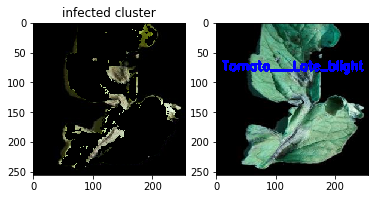

('global_feature is', array([[ 1.50252621e+02,  1.05543910e+02,  1.11395170e+04,
         1.40024280e+00, -3.13444552e-01,  1.36807948e+02,
         7.84707127e-01,  8.51805884e-01,  9.02465877e-01,
         1.88705709e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(25L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

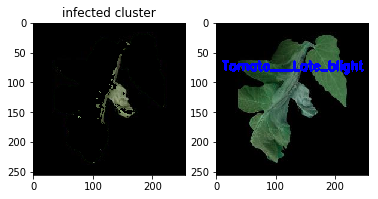

('global_feature is', array([[ 1.49636912e+02,  1.03081781e+02,  1.06258536e+04,
         1.45327065e+00, -3.04036763e-01,  8.13574280e+02,
         8.95454731e-01,  7.36983884e-01,  7.58144297e-01,
         7.82437254e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(26L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

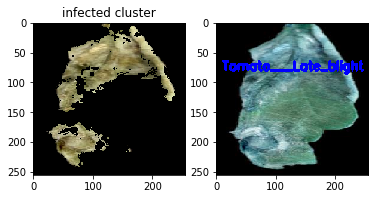

('global_feature is', array([[ 1.49996593e+02,  1.01578896e+02,  1.03182722e+04,
         1.49485478e+00, -3.17543797e-01,  9.24144039e+02,
         8.83117759e-01,  8.11614239e-01,  8.27146594e-01,
         7.25501353e+00]]))
('PREDICTION RESULT', 2)
[STATUS] PREDICTION ARRAY(27L,)


<Figure size 720x720 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

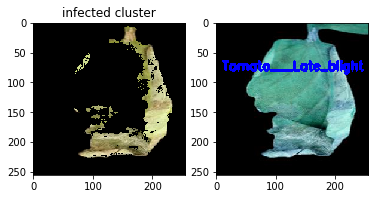

In [97]:
test_path="D:\\test_tomato1"
labels = []
test_labels = os.listdir(test_path)
prediction_array=[]
global_features=[]
# print(test_labels)
i, j = 0, 0
k = 0
img_mode=[]
for file in glob.glob(test_path + "/*.jpg"):

            ip_img = cv2.imread(file)
        
            plt.figure(figsize=(10, 10))
            b,g,r = cv2.split(ip_img)       # get b,g,r
            ip_img = cv2.merge([r,g,b])     # switch it to rgb
            fixed_size=(height,width)
            plt.subplots_adjust(bottom=1.0, right=1.8, top=3.0, wspace = 0.5, hspace=0.5)
#             plt.subplot(661),plt.imshow(ip_img),plt.title('ORIGINAL')
#             fixed_size=(256,256)
            image = cv2.resize(ip_img, fixed_size)
#             plt.subplot(662),plt.imshow(image),plt.title('Resized Image')
            ###HISTOGRAM EQUALIZATION####
            img_out = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)
            img_out[:,:,0]=cv2.equalizeHist(img_out[:,:,0])
            img_equi=cv2.cvtColor(img_out, cv2.COLOR_YUV2BGR)
#             plt.subplot(663),plt.imshow(img_equi),plt.title('EQUILIZED IMAGE')
          ####RGB TO LAB COLOR SPACE CONVERSION###
            plt.figure(figsize=(20, 20))    
            lab_image = cv2.cvtColor(img_equi, cv2.COLOR_BGR2LAB)
#             plt.subplot(664),plt.imshow(lab_image),plt.title('LAB_IMAGE')

            ###Splitting LAB Color Model####
#             plt.figure(figsize=(20, 20))    
            l_channel,a_channel,b_channel = cv2.split(lab_image)        
#             plt.subplot(665),plt.imshow(l_channel),plt.title('L Channel Image')
#             plt.subplot(666),plt.imshow(a_channel),plt.title('A Channel Image')
#             plt.subplot(667),plt.imshow(b_channel),plt.title('B Channel Image')
            ####k means clustering of B channel######
            vectorized=b_channel.reshape(-1,1)
            vectorized=np.float32(vectorized)
            criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,10, 1.0)
            k=3
            res1,label,center=cv2.kmeans(vectorized,k,None,
            criteria,10,cv2.KMEANS_RANDOM_CENTERS)
            center=np.uint8(center)
            c=(label.flatten())
            res2 = center[c.astype(int)]
            res3= res2.reshape((a_channel.shape))
            # c=(label==0).flatten()
            reshape_label=label.reshape(fixed_size)
#             plt.subplot(668),plt.imshow(reshape_label,cmap='gray')
#             plt.subplot(669),plt.imshow(res3)
            ####Finding Infected Cluster###########3
            num1=center[0]
            num2=center[1]
            num3=center[2]
            if (num1 < num2) and (num1 < num3):
                smallest_num = num1
            elif (num2 < num1) and (num2 < num3):
                smallest_num = num2
            else:
                smallest_num = num3
#             print("The smallest of the 3 numbers is : ", smallest_num)

            cluster1=np.zeros(lab_image.shape,np.uint8)
            cluster2=np.zeros(lab_image.shape,np.uint8)
            cluster3=np.zeros(lab_image.shape,np.uint8)
            cluster4=np.zeros(lab_image.shape,np.uint8)
            for x in range(height-1):
                    for y in range(width-1):
                        if np.all((res3[x,y])==center[0]):
                            cluster1[x,y]=image[x,y]
                            if smallest_num==center[0]:
                                infected_cluster=cluster1
                        elif np.all((res3[x,y])==center[1]):
                            cluster2[x,y]=image[x,y]
                            if smallest_num==center[1]:
                                infected_cluster=cluster2
                        elif np.all((res3[x,y])==center[2]):
                            cluster3[x,y]=image[x,y]   
                            if smallest_num==center[2]:
                                infected_cluster=cluster3
    #                     elif np.all((res3[x,y])==center[3]):
    #                         cluster4[x,y]=ip_img[x,y]

            plt.figure(figsize=(6, 6))
#             plt.subplot(141),plt.imshow(cluster1),plt.title('cluster1')
#             plt.subplot(142),plt.imshow(cluster2),plt.title('cluster2')
#             plt.subplot(143),plt.imshow(cluster3),plt.title('cluster3')
            plt.subplot(121),plt.imshow(infected_cluster),plt.title('infected cluster')

        
            img_out = cv2.cvtColor(infected_cluster, cv2.COLOR_RGB2GRAY)
#             plt.subplot(144),plt.imshow(img_out, cmap='gray'),plt.title('Gray_infected_image')
            ##########Statistical Feature Extraction#######
            for x in range (1,height-1):
              for y in range (1,width-1):

                pixel = img_out[x,y]
                if np.all((img_out[x,y])!=0):
                    img_mode.append(img_out[x,y])
                
                y+=1
            x+=1
            
# a=scipy.stats.skew(img_mode)
            mean_g=(np.mean(img_mode))
            std_g=(np.std(img_mode))
            variance_g=(np.var(img_mode))
            skewness_g=scipy.stats.skew(img_mode)
            kurtosis_g=scipy.stats.kurtosis(img_mode,axis=0,fisher=False) #Pearson Kurtosis 
            mean_g=mean_g.reshape(-1,1)
            std_g=std_g.reshape(-1,1)
            variance_g=variance_g.reshape(-1,1)
            skewness_g=(np.array(skewness_g)).reshape(-1,1)
            kurtosis_g=(np.array(kurtosis_g)).reshape(-1,1)
            ####Finding highest and Lowest Intensity Value#####
            smallest = np.amin(img_out)
            biggest = np.amax(img_out)
#             print('smallest intensity',smallest)
#             print('Largest Intensity',biggest)
            
            
            
            ##########Textual_features_extrcation##########
            g = greycomatrix(img_out, [2], [0], levels=256,normed=True, symmetric=True)
    #         plt.subplot(667),plt.imshow(g, cmap='gray')
            contrast_g=greycoprops(g,'contrast')
            correlation_g=greycoprops(g,'correlation')
            energy_g=greycoprops(g,'energy')
                    # entropy_g=greycoprops(g,'entropy')
            homogeneity_g=greycoprops(g,'homogeneity')
            dissimilarity_g=greycoprops(g,'dissimilarity')
    
            global_feature = np.hstack(([mean_g,std_g,variance_g,kurtosis_g,skewness_g,contrast_g,correlation_g,energy_g,homogeneity_g,dissimilarity_g]))
            print('global_feature is',global_feature)
#             labels.append(current_label)
            global_features.append(global_feature)
            prediction = clf_rf.predict(global_feature.reshape(1,10))[0]
            print('PREDICTION RESULT',prediction)
            prediction_array.append(prediction)
            print("[STATUS] PREDICTION ARRAY{}".format(np.array(prediction_array).shape))
            cv2.putText(ip_img, train_labels[prediction], (10,80), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,0,0), 4)
#         labels.append()
            plt.subplot(122),plt.imshow(cv2.cvtColor(ip_img, cv2.COLOR_BGR2RGB))
            plt.show()
#         ##display the output image
#         cv2.imshow("Test_Image", ip_img)
#         cv2.waitKey(0)


In [ ]:


plt.imshow(component)

In [ ]:
#### Mean of AB Channel#########33

In [ ]:
c=(label==0).flatten()
c.shape

In [ ]:
ip_img[0,0,0:2]

In [ ]:
ip_img[0,0,0]

In [ ]:
ip_img[0,0,1]

In [ ]:
ip_img[0,0,2]

In [ ]:
lab_image[0,0,0]

In [ ]:
lab_image[0,0,1]

In [ ]:
plt.hist(res3.ravel(),127,[0,127]); plt.show()

In [ ]:
centers

In [ ]:

img = cv.medianBlur(img_out,5)


Co-occurance Matrix

In [ ]:
correlation_g

In [ ]:
energy_g

In [ ]:
homogeneity_g

In [ ]:
contrast_g

In [ ]:
m, s = cv2.meanStdDev(res3)

In [ ]:
center[1]

In [ ]:
plt.imshow(res)

In [ ]:
plt.imshow(image-res)

In [ ]:
cv2.imshow('cluster1',component)

In [ ]:
component[150,100]

In [ ]:
res3[100,100]

In [ ]:
res3[100,100]=(200,100,123)

In [ ]:
res3[100,100]

In [ ]:
if (np.all(res3[100,100]==(200,10,123))):
    print('hi')